#  Recocido Simulado con municipios de México
## Víctor David García Medina

A partir de las coordenadas de las ciudades de México, en cada ejecución del algoritmo dar:
- El número de ciudades
- Hacer una selección aleatoria de N ciudades de México
- Resolver el problema para ese conjunto de ciudades
- Para $N$ pequeña comparar la solución obtenida con la de solución optima que brinda el algoritmo de fuerza bruta.
- Probar con 3 valores distintos de $N$ y uno donde se contemplent las ciudades capitales
- Mostrar graficamente la solución obtenida

El recocido simulado es un algoritmo de optimización probabilístico inspirado en el proceso que se realiza en el metal. Este proceso involucra calentar el material a altas temperaturas y gradualmente enfriarlo para remover impurezas y optimizar la estructura. Similarmente, el recocido simulado se utiliza para hallar una solución aproximada a un problema de optimización. Un resumen rápido sería el siguiente:

* Función Objetivo
    * Definir una función objetivo que se pretende optimizar, esta función representa una solución de calidad
    
* Solución inicial
    * Empezar con una solución, se puede elegir de manera aleatoria o con alguna heurística
    
* Cronograma de la temperatura
    * Este proceso involucra un parámetro de temperatura que controla la probabilidad de aceptar una solución peor. En altas temperaturas, el algoritmo es más propenso a hallar malas soluciones, mientras la temperatura disminuye el algoritmo se vuelve más selectivo
    
* Generar vecinos
    * Defenir un mecanismo para generar solulciones vecinas. Una solución vecina es aquella que está cercana a la solución actual, y el algoritmo busca soluciones vecinas que sean mejores a la actual
    
* Probabilidad de aceptación
    * Cuando se cambia la solución por alguna solución vecina, se calcula la probabilidad de cambio en la función objetivo. Si la nueva solución es mejor se acepta. Si la nueva solución es peor, se acepta con una probabilidad que depende tanto de la magnitud de enfriamento como la temperatura actual. Esta probabilidad permite al algoritmo evitar óptimos locales
  
* Cronología de enfriamiento
    * Se baja gradualmente la temperatura de acuerdo a la cronología. Esto simula el proceso de recocido en el cual el material se enfría con el tiempo
    
* Finalización
    * Se repite el proceso hasta que se alcance la condición, la cual puede ser alcanzar alguna temperatura fija o se acabe el número de iteraciones

Para la implementación ocupo un archivo shp disponible en la página del INEGI que contiene la información de los municipios de México en 2016. Además utilizaré las siguientes bibliotecas

In [1]:
import shapefile #Para poder usar el archivo shp de municipios
import matplotlib.pyplot as plt # para los plots
import geopandas as gpd # para las tablas con la informaación geográfica
import os #para evitar inconsistencias en las direcciones de los archivos
import random # Para reordenar de manera aleatoria las ciudades
import math # para las operaciones matemáticas 
from shapely.geometry.point import Point # Para calcular distancias entre ciudades
import warnings
import time
# Ignorar todos los warnings
warnings.filterwarnings('ignore')

Los shapefile son archivos que deben estar dentro de la misma carpeta junto con otros archivos que contienen la meta data: coordenadas, polígonos, área, perímetro, id etc. Geopandas es una librería parecida a pandas que nos permite trabajar con estos archivos en forma de data frames. Veamos cómo luce el archivo:

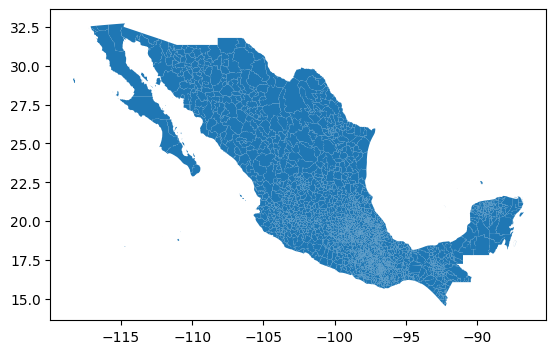

In [3]:
dr = os.path.join('muni_2016gw', 'muni_2016gw.shp') #el archivo shp se encuentra en la carpeta muni_2016w
mexico_shapefile = gpd.read_file(dr) 
mexico_shapefile.plot()
plt.show()

El mapa es la división de México en municipios, para poder hacerlo manejable lo convertimos a un dataframe (Geopandas dataframe)

In [4]:
gdf = gpd.read_file(dr) # Creamos un objeto geopandas a partir del archivo shp
columns_to_drop = ['OBJECTID', 'AREA', 'PERIMETER', 'COV_', 'COV_ID'] #Eliminamos columnas que no vamos a necesitar
gdf = gdf.drop(columns=columns_to_drop)
# gdf = gdf.to_crs('EPSG:4326')
gdf['center'] = gdf['geometry'].centroid #Calculamos el centroide de cada municipio
gdf['center_x'] = gdf['center'].x #Coorenada x de cada centroide
gdf['center_y'] = gdf['center'].y #Coordenada y de cada centroide


In [5]:
print(gdf.crs)

EPSG:4326


In [6]:

gdf["NOM_MUN"] = gdf["NOM_MUN"].apply(lambda x: x.encode('latin-1').decode('utf-8')) #Evitamos problemas con
gdf["NOM_ENT"] = gdf["NOM_ENT"].apply(lambda x: x.encode('latin-1').decode('utf-8')) #la codificación


# El Geopandas data frame luce así:

In [7]:
gdf

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVEGEO,geometry,center,center_x,center_y
0,01,Aguascalientes,002,Asientos,01002,"POLYGON ((-101.99941 22.21951, -101.99940 22.2...",POINT (-102.04564 22.12651),-102.045638,22.126508
1,01,Aguascalientes,011,San Francisco de los Romo,01011,"POLYGON ((-102.14088 22.07534, -102.14086 22.0...",POINT (-102.22902 22.03307),-102.229021,22.033071
2,01,Aguascalientes,007,Rincón de Romos,01007,"POLYGON ((-102.18902 22.36244, -102.18951 22.3...",POINT (-102.34073 22.26741),-102.340729,22.267408
3,01,Aguascalientes,008,San José de Gracia,01008,"POLYGON ((-102.35385 22.12064, -102.35426 22.1...",POINT (-102.52584 22.14663),-102.525839,22.146635
4,01,Aguascalientes,005,Jesús María,01005,"POLYGON ((-102.31034 22.03716, -102.30653 22.0...",POINT (-102.44565 21.93212),-102.445649,21.932118
...,...,...,...,...,...,...,...,...,...
2453,32,Zacatecas,020,Jerez,32020,"POLYGON ((-102.89721 22.90452, -102.89587 22.9...",POINT (-102.99197 22.72548),-102.991973,22.725483
2454,32,Zacatecas,004,Benito Juárez,32004,"POLYGON ((-103.55467 21.57663, -103.55410 21.5...",POINT (-103.58180 21.49563),-103.581799,21.495632
2455,32,Zacatecas,057,Trancoso,32057,"POLYGON ((-102.24610 22.73451, -102.24615 22.7...",POINT (-102.31200 22.75563),-102.312003,22.755629
2456,32,Zacatecas,019,Jalpa,32019,"POLYGON ((-102.80528 21.67101, -102.80462 21.6...",POINT (-102.99829 21.62368),-102.998293,21.623682


Esta tabla consta de las siguientes columnas:
* CVE_ENT: Numeración del estado
* NOM_ENT: Nombre del estado
* CVE_MUN: Numeración del municipio
* NOM_MUN: Nombre del municipio
* CVE_GEO: Es la concatenación CVE_ENT + CVE_MUM
* geometry: Un conjunto de puntos geográficos (longitud, latitud) que forman el polígono que delimita al municipio
* center: El centroide del municipio

Esta tabla consta de 2458 filas, cada una de ellas representa un municipio, al ser demasiado grande como para ser consultable decidí definir 3 funciones:

* consult_mun(str): Esta función recibe un string que sea nombre de algún municipio y regresa la tabla con los municipios que tengan nombre similar
* consult_state(str): Esta función recibe un string que sea nombre de un Estado y regresa una lista de todos sus municipios, hay que tener cuidado de escribir el nombre del estado con acentos.
* pick_mun(array): Esta función recibe un array de nombres de municipios y crea un diccionario donde a cada municipio se le asigna su centroide que será el punto por el cual pasará el viajero (pensando en el recocido simulado como la solución al problema del viajero)


IMPORTANTE: Existen varios municipios que tienen el mismo nombre por lo que sólo escribir el nombre del municipio no es suficiente, para esto se utilizará "CVEGEO" que es un id único para cada estado

In [8]:
def consult_mun(str): #Regresa los municipios que tengan nombre parecido a un string dado
    return gdf[gdf["NOM_MUN"].str.contains(str, case=False)] 
def consult_state(str): #Regresa en una lista los municipios de un estado (se deben usar acentos)
    nom_mun_list = list(gdf[gdf["NOM_ENT"].str.contains(str, case=False)]["CVEGEO"])
    return nom_mun_list


In [9]:
def pick_mun(array):
    mun_info = {}
    df = gdf[gdf["NOM_MUN"].isin(array)]
    for i in range(len(df)):
        mun_info[df.iloc[i]["NOM_MUN"]] = df.iloc[i]["center"]
    if len(mun_info) != len(array):
        print("no se hallaron algunos municipios, consulta su nombre completo con la funcion consult_mun")
    return mun_info
def pick_mun_cvegeo(array):
    mun_info ={}
    df = gdf[gdf["CVEGEO"].isin(array)]
    for i in range(len(df)):
        mun_info[df.iloc[i]["CVEGEO"]] = df.iloc[i]["center"]
    return mun_info

Veamos cómo funcionan las funciones:

In [10]:
consult_mun("vigas") #El nombre oficial del municipio es "Las Vigas de Ramírez"
#El nombre oficial es el que se requiere para hacer el recocido

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVEGEO,geometry,center,center_x,center_y
2257,30,Veracruz de Ignacio de la Llave,132,Las Vigas de Ramírez,30132,"POLYGON ((-97.06833 19.68503, -97.06774 19.684...",POINT (-97.09478 19.62228),-97.094782,19.622284


In [11]:
consult_state("Ciudad de México") 
#Regresa un listado con los municipios de la ciudad de México
#En este geopandas se considera a CDMX como estado y las antiguas alcaldias como municipios

['09010',
 '09012',
 '09015',
 '09017',
 '09011',
 '09002',
 '09003',
 '09013',
 '09004',
 '09016',
 '09005',
 '09008',
 '09007',
 '09006',
 '09009',
 '09014']

In [12]:
delegaciones = consult_state("Ciudad de México") 
pick_mun_cvegeo(delegaciones)  #Regresa un diccionario, cada municipio con su centro en coordenadas longitud, latitud

{'09010': <POINT (-99.247 19.336)>,
 '09012': <POINT (-99.206 19.198)>,
 '09015': <POINT (-99.149 19.431)>,
 '09017': <POINT (-99.093 19.43)>,
 '09011': <POINT (-99.003 19.277)>,
 '09002': <POINT (-99.182 19.485)>,
 '09003': <POINT (-99.15 19.327)>,
 '09013': <POINT (-99.09 19.245)>,
 '09004': <POINT (-99.311 19.325)>,
 '09016': <POINT (-99.205 19.428)>,
 '09005': <POINT (-99.116 19.504)>,
 '09008': <POINT (-99.268 19.269)>,
 '09007': <POINT (-99.057 19.349)>,
 '09006': <POINT (-99.094 19.397)>,
 '09009': <POINT (-99.051 19.139)>,
 '09014': <POINT (-99.161 19.381)>}

Todo esto con la intención de preparar el camino para poder implementar el algoritmo principal: Este algoritmo debe recibir una lista de municipios que el viajero debe recorrer, naturalmente se requieren coordenadas y distancias que es justo lo que calcula la función pick_mun.

Hecho lo anterior empezamos por definir una función que calcula la distancia recorrida al seguir un orden específico de ciudades:


In [13]:
#################################################
# Calcula la distancia de recorrer las ciudades #
# en el orden en que están en la lista          #
#################################################
def calculate_total_distance(order, cities):
    total_distance = 0
    for i in range(len(order) - 1):
        city1 = cities[order[i]]
        city2 = cities[order[i + 1]]
        total_distance += city1.distance(city2)
    return total_distance

Ahora la función que calcula la ruta óptima:

In [14]:
################################################################################
# Cities es la lista de ciudades a recorrer                                    #
# La temperatura por default es 1000 pero se puede modificar                   # 
# La razón de enfriamiento por default es 0.995 pero también puede cambiarse   #
# Se harán  1000 iteraciones por default, también se puede cambiar             #
################################################################################


def simulated_annealing(cities, initial_temperature=1000, cooling_rate=0.995, num_iterations=1000):
    inicio = time.time()
    current_order = list(cities.keys()) 
    random.shuffle(current_order) # Se cambian las posiciones de los municipios de manera aleatoria
    current_distance = calculate_total_distance(current_order, cities) # Se calcula la distancia
    
    best_order = current_order.copy() #Se guarda el orden 
    best_distance = current_distance # Se guarda la distancia
    
    temperature = initial_temperature #Temperatura inicial

    for _ in range(num_iterations): # Empieza la iteración...
        new_order = current_order.copy()
        # Cambia dos ciudades de manera aleatoria
        index1, index2 = random.sample(range(len(new_order)), 2)
        new_order[index1], new_order[index2] = new_order[index2], new_order[index1]

        new_distance = calculate_total_distance(new_order, cities) # Calcula la nueva distancia total
        
        # Verifica si el nuevo órden de visitas es mejor utilizando la temperatura para cambiarlo con cierta probabilidad
        if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temperature):
            current_order = new_order
            current_distance = new_distance

            # Si el nuevo órden es mejor se actualiza el valor del mejor
            if current_distance < best_distance:
                best_order = current_order.copy()
                best_distance = current_distance

        # Ahora se disminuye la temperatura 
        temperature *= cooling_rate
        #########################################################################
        # Empieza otra iteración con nueva temperatura y nuevo orden de ciudades#
        #########################################################################

    fin = time.time()
    print(f"##Tiempo de ejecución: {fin-inicio} segundos \n")
    print(f"## El orden a visitar los municipios es \n {best_order}  \n")
    print(f"##La mejor distancia hallada es: {best_distance} ")
 
    return best_order, best_distance #Finalmente se regresa el orden y la distancia que fueron mejores.


# Primer ejemplo
Empezamos por unas pocas ciudades:

In [15]:
mun_array = ["Xalapa", "Tijuana", "Perote", "Iztapalapa", "Mérida", "Centro", "Puebla" ]
cities = pick_mun(mun_array)

In [16]:
best_order, best_distance = simulated_annealing(cities,1500, 0.8999, 1000)



##Tiempo de ejecución: 0.05858206748962402 segundos 

## El orden a visitar los municipios es 
 ['Mérida', 'Centro', 'Xalapa', 'Perote', 'Puebla', 'Iztapalapa', 'Tijuana']  

##La mejor distancia hallada es: 33.11180969364076 


Este es un ejemplo pequeño y luego de probarlo con diferentes valores parece estar cerca de lo que intuitivamente luce como una ruta óptima

# El mismo ejemplo pero a fuerza bruta

In [17]:
from itertools import permutations

In [18]:
def calcular_distancia(coord1, coord2):
    # Función para calcular la distancia euclidiana entre dos puntos
    return math.sqrt((coord1.x - coord2.x)**2 + (coord1.y - coord2.y)**2)

def calcular_distancia_total(ruta, coordenadas):
    # Función para calcular la distancia total de una ruta sin volver a la ciudad de origen
    distancia_total = 0
    for i in range(len(ruta) - 1):
        ciudad_actual = coordenadas[ruta[i]]
        siguiente_ciudad = coordenadas[ruta[i + 1]]
        distancia_total += calcular_distancia(ciudad_actual, siguiente_ciudad)
    return distancia_total


In [19]:
import time
municipios = list(cities.keys())
mejor_ruta = None
mejor_distancia = float('inf')

inicio_tiempo = time.time()
for ruta_permutada in permutations(municipios):
    distancia_actual = calcular_distancia_total(ruta_permutada, cities)
    if distancia_actual < mejor_distancia:
        mejor_distancia = distancia_actual
        mejor_ruta = ruta_permutada
        
fin_tiempo = time.time()
tiempo_total = fin_tiempo - inicio_tiempo

print("Mejor ruta:", mejor_ruta)
print("Distancia total:", mejor_distancia)
print(tiempo_total)

Mejor ruta: ('Tijuana', 'Iztapalapa', 'Puebla', 'Perote', 'Xalapa', 'Centro', 'Mérida')
Distancia total: 33.11180969364076
0.4668614864349365


En ocaciones ambos métodos arrojan la misma distancia con diferente órden, siempre el recocido simulado encuentra una solución más rápido (la cual no necesariamente es la óptima)

# Ejemplo delegaciones en CDMX
Primero generamos la lista con las delegaciones

In [20]:
consult_state("Ciudad de México")

['09010',
 '09012',
 '09015',
 '09017',
 '09011',
 '09002',
 '09003',
 '09013',
 '09004',
 '09016',
 '09005',
 '09008',
 '09007',
 '09006',
 '09009',
 '09014']

ahora con las delegaciones consultamos las coordenadas de los centroides y ejecutamos el algoritmo:

In [21]:
delegaciones = consult_state("Ciudad de México")
_delegaciones = pick_mun_cvegeo(delegaciones)
best_order2, best_distance2 = simulated_annealing(_delegaciones,10000, 0.99, 15000)




##Tiempo de ejecución: 1.5638604164123535 segundos 

## El orden a visitar los municipios es 
 ['09011', '09007', '09003', '09006', '09017', '09005', '09002', '09016', '09015', '09014', '09010', '09004', '09008', '09012', '09013', '09009']  

##La mejor distancia hallada es: 1.1881698457869914 


Dependiendo de la ejecución se obtendrán diferentes resultados, veamos en un mapa cómo se vería el recorrido. Primero guardamos el resultado en un data frame agregando una columna "indice" que indica el órden en que el municipio es visitado

In [22]:
filtered_gdf2 = gdf[(gdf['CVEGEO'].isin(best_order2)) & (gdf['NOM_ENT'] == "Ciudad de México")]
mun_index_mapping = {mun: index for index, mun in enumerate(best_order2)}
filtered_gdf2['indice'] = filtered_gdf2['CVEGEO'].map(mun_index_mapping)
#print(filtered_gdf2[["NOM_MUN" , "indice"]])

In [23]:
filtered_gdf2[["NOM_MUN" , "indice", "center"]].sort_values(by='indice')

,NOM_MUN,indice,center
269,Tláhuac,0,POINT (-99.00282 19.27700)
277,Iztapalapa,1,POINT (-99.05680 19.34917)
271,Coyoacán,2,POINT (-99.15038 19.32667)
278,Iztacalco,3,POINT (-99.09433 19.39691)
268,Venustiano Carranza,4,POINT (-99.09311 19.43050)
275,Gustavo A. Madero,5,POINT (-99.11586 19.50407)
270,Azcapotzalco,6,POINT (-99.18211 19.48533)
274,Miguel Hidalgo,7,POINT (-99.20457 19.42806)
267,Cuauhtémoc,8,POINT (-99.14906 19.43137)
280,Benito Juárez,9,POINT (-99.16113 19.38064)


Y con un mapa de calor indicamos en qué orden se visitó cada municipio:

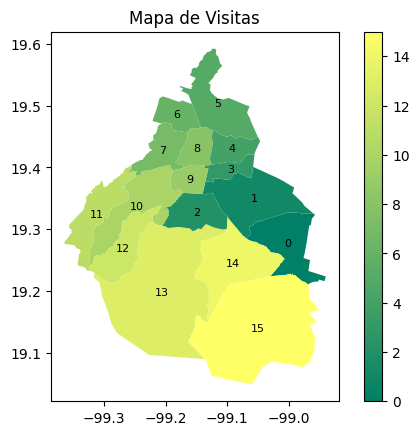

In [24]:
ax = filtered_gdf2.plot(column='indice', cmap='summer', legend=True)

ax.set_aspect('equal')

for x, y, label in zip(filtered_gdf2.geometry.centroid.x, filtered_gdf2.geometry.centroid.y, filtered_gdf2['indice']):
    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')

ax.set_title('Mapa de Visitas')
plt.show()

El resultado tiene coherencia, el recorrido se hace en zig-zag o en espiral.

# Ejemplo municipios en Veracruz

Primero consultamos todos los CVEGEO del estado de Veracruz. Recordar que el CVEGEO es un ID único de cada municipio para evitar repeticiones de municipios que pueden estar en otro estado de la república. 

In [25]:
consult_state("Veracruz")

['30059',
 '30018',
 '30208',
 '30136',
 '30073',
 '30196',
 '30182',
 '30171',
 '30061',
 '30095',
 '30031',
 '30154',
 '30144',
 '30142',
 '30149',
 '30107',
 '30156',
 '30168',
 '30117',
 '30163',
 '30184',
 '30072',
 '30081',
 '30138',
 '30199',
 '30140',
 '30054',
 '30074',
 '30120',
 '30210',
 '30190',
 '30127',
 '30002',
 '30100',
 '30145',
 '30118',
 '30007',
 '30042',
 '30008',
 '30162',
 '30005',
 '30088',
 '30101',
 '30047',
 '30004',
 '30170',
 '30189',
 '30015',
 '30116',
 '30112',
 '30057',
 '30143',
 '30087',
 '30055',
 '30051',
 '30063',
 '30043',
 '30029',
 '30155',
 '30202',
 '30211',
 '30060',
 '30158',
 '30180',
 '30010',
 '30175',
 '30102',
 '30181',
 '30036',
 '30188',
 '30150',
 '30079',
 '30161',
 '30027',
 '30048',
 '30094',
 '30201',
 '30113',
 '30037',
 '30147',
 '30198',
 '30134',
 '30108',
 '30124',
 '30125',
 '30148',
 '30058',
 '30091',
 '30013',
 '30169',
 '30014',
 '30178',
 '30038',
 '30212',
 '30141',
 '30083',
 '30105',
 '30032',
 '30173',
 '30123',


Ahora ejecutamos el algoritmo y obtendremos la lista de los CVEGOS en el orden en que deben ser visitados

In [26]:
municipios = consult_state("Veracruz")
_municipios = pick_mun_cvegeo(municipios)
best_order_ver, best_distance_ver = simulated_annealing(_municipios,15000, 0.9998, 15000)



##Tiempo de ejecución: 21.53058624267578 segundos 

## El orden a visitar los municipios es 
 ['30129', '30056', '30040', '30094', '30089', '30002', '30102', '30069', '30160', '30151', '30112', '30107', '30009', '30211', '30043', '30086', '30187', '30023', '30111', '30204', '30081', '30116', '30206', '30070', '30142', '30140', '30046', '30181', '30155', '30202', '30073', '30003', '30075', '30066', '30198', '30071', '30013', '30027', '30076', '30178', '30092', '30103', '30030', '30199', '30082', '30093', '30088', '30197', '30004', '30195', '30012', '30015', '30018', '30141', '30144', '30029', '30106', '30117', '30138', '30113', '30104', '30122', '30049', '30060', '30051', '30038', '30191', '30161', '30196', '30034', '30080', '30090', '30173', '30188', '30146', '30137', '30041', '30185', '30101', '30028', '30208', '30001', '30005', '30125', '30100', '30016', '30131', '30068', '30171', '30183', '30175', '30164', '30052', '30180', '30190', '30057', '30033', '30014', '30166', '30091', '3000


Esta lista no es tan amigable a la vista por lo que al igual que en el ejemplo anterior formamos una nueva columna que indica la posición en la lista, es decir la $(n+1)$-ésima fila es el $n$-ésimo municipio visitado 





In [27]:
filtered_gdf_ver = gdf[(gdf['CVEGEO'].isin(best_order_ver)) ]
mun_index_mapping = {mun: index for index, mun in enumerate(best_order_ver)}
filtered_gdf_ver['indice'] = filtered_gdf_ver['CVEGEO'].map(mun_index_mapping)

In [28]:
filtered_gdf_ver[["NOM_MUN" , "indice", "center"]].sort_values(by='indice')

,NOM_MUN,indice,center
2207,Platón Sánchez,0,POINT (-98.37572 21.29478)
2194,Chiconamel,1,POINT (-98.46718 21.25380)
2200,Coatzintla,2,POINT (-97.53741 20.42746)
2157,Juan Rodríguez Clara,3,POINT (-95.36585 17.98154)
2192,Jáltipan,4,POINT (-94.71507 17.87042)
...,...,...,...
2228,Otatitlán,207,POINT (-96.03426 18.16746)
2096,Soteapan,208,POINT (-94.90080 18.23698)
2195,Playa Vicente,209,POINT (-95.64517 17.76700)
2090,Las Choapas,210,POINT (-93.95724 17.53584)


Ahora para tener una idea se puede hacer un mapa de calor utilizando el valor "indice" como parámetro.

<Figure size 1200x800 with 0 Axes>

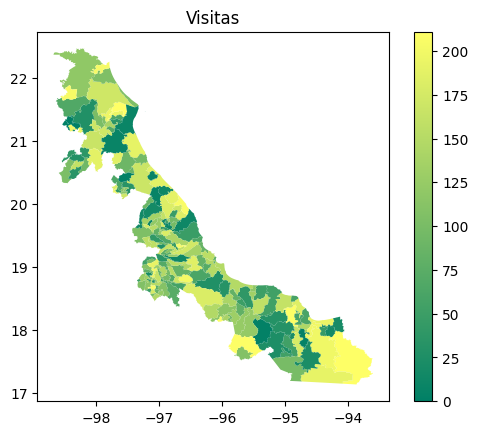

In [29]:
plt.figure(figsize=(12, 8)) 
ax = filtered_gdf_ver.plot(column='indice', cmap='summer', legend=True)
ax.set_aspect('equal')
#for x, y, label in zip(filtered_gdf_ver.geometry.centroid.x, filtered_gdf_ver.geometry.centroid.y, filtered_gdf_ver['indice']):
#    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')
ax.set_title('Visitas')

plt.show()


Y eso es más amigable que hacer un plot con el índice de cada municipio

<Figure size 1200x800 with 0 Axes>

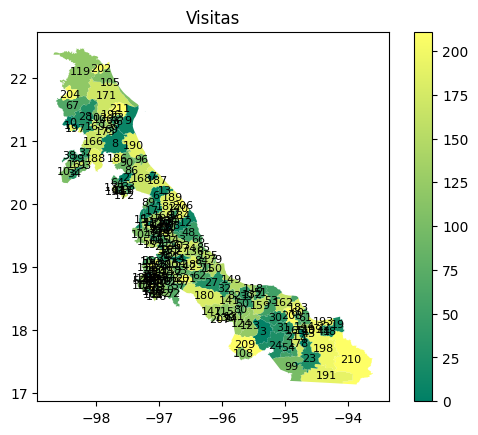

In [30]:
plt.figure(figsize=(12, 8)) 
ax = filtered_gdf_ver.plot(column='indice', cmap='summer', legend=True)
ax.set_aspect('equal')
for x, y, label in zip(filtered_gdf_ver.geometry.centroid.x, filtered_gdf_ver.geometry.centroid.y, filtered_gdf_ver['indice']):
    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')
ax.set_title('Visitas')

plt.show()

# Ejemplo con ciudades aleatorias
Tomemos de manera aleatoria 30 elementos del geopandas que contiene a taodos los municipios

In [31]:
sampled_gdf = gdf.sample(n=30, random_state=42) 

In [32]:
sampled_gdf[["NOM_ENT", "CVE_MUN", "NOM_MUN", "CVEGEO"]]

,NOM_ENT,CVE_MUN,NOM_MUN,CVEGEO
1837,San Luis Potosí,001,Ahualulco,24001
2291,Veracruz de Ignacio de la Llave,020,Atlahuilco,30020
1351,Oaxaca,270,San Miguel Huautla,20270
1690,Puebla,149,Santiago Miahuatlán,21149
252,Chihuahua,045,Meoqui,08045
353,Guanajuato,022,Ocampo,11022
1607,Puebla,140,San Pedro Cholula,21140
1640,Puebla,044,Cuyoaco,21044
237,Chihuahua,043,Matachí,08043
1948,Sonora,019,Cananea,26019


In [33]:
nom_mun_values = sampled_gdf['CVEGEO'].tolist()

In [34]:
# nom_mun_values

Repitamos el proceso:

In [37]:
_nom_mun_values = pick_mun_cvegeo(nom_mun_values)
best_order_random, best_distance_random = simulated_annealing(_nom_mun_values,10000, 0.99998, 20000)



##Tiempo de ejecución: 4.123217582702637 segundos 

## El orden a visitar los municipios es 
 ['23011', '08045', '13018', '21044', '21140', '12012', '12049', '27001', '30074', '21149', '30020', '20454', '30049', '20270', '24001', '24004', '14004', '08043', '26019', '08051', '26062', '16086', '32028', '31006', '21075', '13038', '21073', '21011', '20336', '11022']  

##La mejor distancia hallada es: 133.71622773399247 


In [38]:
filtered_gdf_random = gdf[(gdf['CVEGEO'].isin(best_order_random))]
mun_index_mapping = {mun: index for index, mun in enumerate(best_order_random)}
filtered_gdf_random['indice'] = filtered_gdf_random['CVEGEO'].map(mun_index_mapping)

El orden para visitar los municipios es:

In [39]:
filtered_gdf_random[["NOM_MUN","NOM_ENT", "indice"]].sort_values(by='indice')

,NOM_MUN,NOM_ENT,indice
1813,Puerto Morelos,Quintana Roo,0
252,Meoqui,Chihuahua,1
508,Chapulhuacán,Hidalgo,2
1640,Cuyoaco,Puebla,3
1607,San Pedro Cholula,Puebla,4
407,Ayutla de los Libres,Guerrero,5
440,Pilcaya,Guerrero,6
1976,Balancán,Tabasco,7
2109,Huiloapan de Cuauhtémoc,Veracruz de Ignacio de la Llave,8
1690,Santiago Miahuatlán,Puebla,9


<Figure size 2000x2000 with 0 Axes>

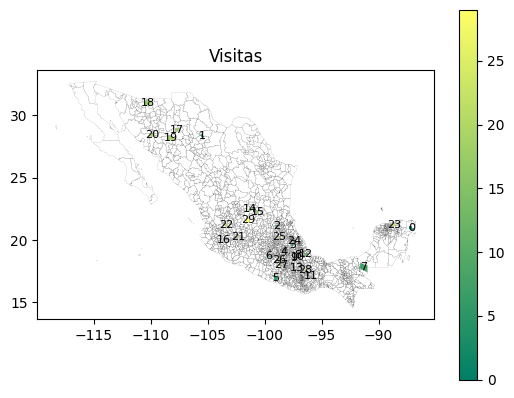

In [40]:

plt.figure(figsize=(20, 20)) 
ax = gdf.plot(facecolor='none', edgecolor='black', linewidth=0.05) 
filtered_gdf_random.plot(ax=ax, column='indice', cmap='summer', legend=True)


for x, y, label in zip(filtered_gdf_random.geometry.centroid.x, filtered_gdf_random.geometry.centroid.y, filtered_gdf_random['indice']):
    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')

ax.set_title('Visitas')


plt.show()


# Capitales
Empiezo por tomar en cuenta la lista de las capitales:


In [41]:
capitales = [
    "Aguascalientes",
    "Mexicali",
    "La Paz",
    "Campeche",
    "Tuxtla Gutiérrez",
    "Chihuahua",
    "Saltillo",
    "Colima",
    "Durango",
    "Toluca de Lerdo",
    "Guanajuato",
    "Chilpancingo de los Bravo",
    "Pachuca de Soto",
    "Guadalajara",
    "Morelia",
    "Cuernavaca",
    "Tepic",
    "Monterrey",
    "Oaxaca de Juárez",
    "Puebla",
    "Querétaro",
    "Chetumal",
    "San Luis Potosí",
    "Culiacán",
    "Hermosillo",
    "Villahermosa",
    "Victoria",
    "Tlaxcala",
    "Xalapa",
    "Mérida",
    "Zacatecas",
    "Othón P. Blanco",
    "Centro",
    "Coyoacán"
]

Vemos el dataframe de las capitales:

In [42]:
gdf[(gdf['NOM_MUN'].isin(capitales))][["CVE_ENT","NOM_ENT", "NOM_MUN", "CVEGEO"]]

,CVE_ENT,NOM_ENT,NOM_MUN,CVEGEO
6,01,Aguascalientes,Aguascalientes,01001
14,02,Baja California,Mexicali,02002
18,03,Baja California Sur,La Paz,03003
22,04,Campeche,Campeche,04002
69,05,Coahuila de Zaragoza,Saltillo,05030
72,06,Colima,Colima,06002
160,07,Chiapas,Tuxtla Gutiérrez,07101
217,08,Chihuahua,Chihuahua,08019
271,09,Ciudad de México,Coyoacán,09003
286,10,Durango,Durango,10005


Ahora guardamosd los CVEGEO's en una lista para poder aplicar el algoritmo:

In [43]:
capitales_cvgeo = list(gdf[(gdf['NOM_MUN'].isin(capitales))]["CVEGEO"])
print(capitales_cvgeo)

['01001', '02002', '03003', '04002', '05030', '06002', '07101', '08019', '09003', '10005', '11043', '11015', '12029', '13048', '14039', '15070', '16053', '17007', '18017', '19039', '20067', '21114', '22014', '23004', '24028', '25006', '26030', '27004', '28041', '29033', '30087', '31050', '32056']


In [44]:
_capitales_cvgeo = pick_mun_cvegeo(capitales_cvgeo)
best_order_capitales, best_distance_capitales = simulated_annealing(_capitales_cvgeo, 10000, 0.9988, 200000)



##Tiempo de ejecución: 44.36094856262207 segundos 

## El orden a visitar los municipios es 
 ['02002', '26030', '03003', '25006', '08019', '10005', '18017', '01001', '32056', '05030', '19039', '28041', '24028', '11043', '22014', '13048', '17007', '12029', '06002', '14039', '11015', '16053', '09003', '15070', '20067', '07101', '27004', '04002', '23004', '31050', '30087', '29033', '21114']  

##La mejor distancia hallada es: 80.03697252868466 


In [45]:
filtered_gdf_capitales = gdf[(gdf['CVEGEO'].isin(best_order_capitales))]
mun_index_mapping = {mun: index for index, mun in enumerate(best_order_capitales)}
filtered_gdf_capitales['indice'] = filtered_gdf_capitales['CVEGEO'].map(mun_index_mapping)

In [46]:
filtered_gdf_capitales[["NOM_MUN","NOM_ENT", "indice"]].sort_values(by='indice')

,NOM_MUN,NOM_ENT,indice
14,Mexicali,Baja California,0
1959,Hermosillo,Sonora,1
18,La Paz,Baja California Sur,2
1879,Culiacán,Sinaloa,3
217,Chihuahua,Chihuahua,4
286,Durango,Durango,5
942,Tepic,Nayarit,6
6,Aguascalientes,Aguascalientes,7
2407,Zacatecas,Zacatecas,8
69,Saltillo,Coahuila de Zaragoza,9


<Figure size 2000x2000 with 0 Axes>

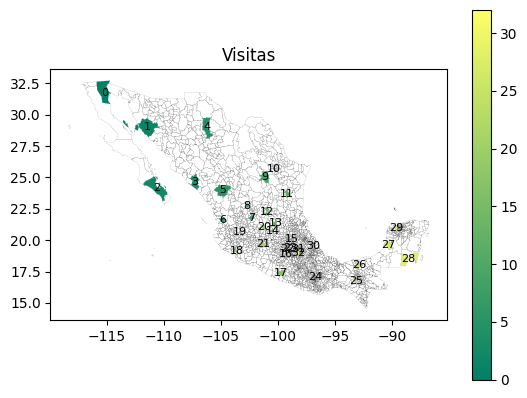

In [47]:
plt.figure(figsize=(20, 20)) 
ax = gdf.plot(facecolor='none', edgecolor='black', linewidth=0.05) 
filtered_gdf_capitales.plot(ax=ax, column='indice', cmap='summer', legend=True)


for x, y, label in zip(filtered_gdf_capitales.geometry.centroid.x, filtered_gdf_capitales.geometry.centroid.y, filtered_gdf_capitales['indice']):
    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')

ax.set_title('Visitas')


plt.show()
